# Imports

In [40]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np
import datetime

from covid19.scrap import get_covid_data
from covid19.covid import get_date_date_cases_greater_than, get_state_data

from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10_6
from bokeh.models.tools import HoverTool
from bokeh.layouts import grid

from bokeh.models import ColumnDataSource, CDSView, BooleanFilter

output_notebook(hide_banner=True)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.rcParams['figure.constrained_layout.use'] = True

'#1f77b4'

# Import data

In [42]:
# Read data from csv file 
# https://covid.saude.gov.br/
data = get_covid_data()
# Preview the first 5 lines of the loaded data 
data.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,2020-01-30,0,0,0,0
1,Norte,RO,2020-01-31,0,0,0,0
2,Norte,RO,2020-02-01,0,0,0,0
3,Norte,RO,2020-02-02,0,0,0,0
4,Norte,RO,2020-02-03,0,0,0,0


# Convert date string to date objects

In [43]:
data.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,2020-01-30,0,0,0,0
1,Norte,RO,2020-01-31,0,0,0,0
2,Norte,RO,2020-02-01,0,0,0,0
3,Norte,RO,2020-02-02,0,0,0,0
4,Norte,RO,2020-02-03,0,0,0,0


In [44]:
data_brasil = data.groupby("data").sum()

print(f"Data do primeiro caso: {get_date_date_cases_greater_than(data, 0)}")
print(f"Data com mais de 10 casos: {get_date_date_cases_greater_than(data, 10)}")
print(f"Data com mais de 100 casos: {get_date_date_cases_greater_than(data, 100)}")
print(f"Data com mais de 1000 casos: {get_date_date_cases_greater_than(data, 1000)}")

Data do primeiro caso: 2020-02-26
Data com mais de 10 casos: 2020-03-07
Data com mais de 100 casos: 2020-03-15
Data com mais de 1000 casos: 2020-03-26


In [45]:
get_state_data(data, "CE").head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
909,Nordeste,CE,2020-01-30,0,0,0,0
910,Nordeste,CE,2020-01-31,0,0,0,0
911,Nordeste,CE,2020-02-01,0,0,0,0
912,Nordeste,CE,2020-02-02,0,0,0,0
913,Nordeste,CE,2020-02-03,0,0,0,0


# Plot data

In [46]:
# state_abrv_vec = np.array(['CE', 'DF', 'PE', 'RJ', 'SP', 'BA', 'AM', 'MS', 'RN'])
state_abrv_vec = np.array(['CE', 'DF', 'RJ', 'SP', 'AM'])
variable_to_plot_vec = np.array(['casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos'])

# We only want values from this date in the plot
date_threshold = get_date_date_cases_greater_than(data, 100)

## Plot de vários estados por data

In [153]:
def get_plot(column_name="casosAcumulados", y_axis_label="Label", width=1200, height=400):

    fig = figure(x_axis_type='datetime', width=width, height=height, x_axis_label="Data", y_axis_label=y_axis_label)
    for i, sigla in enumerate(state_abrv_vec):
        state_data = get_state_data(data, sigla)
        source = ColumnDataSource(state_data)
        fig.line("data", column_name, source=source, legend_label=sigla, color=Category10_6[i])
        fig.circle("data", column_name, source=source, legend_label=sigla, color=Category10_6[i])

    fig.legend.location = "top_left"
#     fig.legend.title = "Estado"
    fig.legend.click_policy = 'hide'
    fig.add_tools(HoverTool(tooltips=[("Casos Acumulados", "@casosAcumulados"), ("Casos Novos", "@casosNovos"), ("Óbitos Acumulados", "@obitosAcumulados"), ("Óbitos Novos", "@obitosNovos")]))
    return fig

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
plot_casosAcumulados = get_plot("casosAcumulados", y_axis_label="Casos Acumulados", width=650, height=300)
plot_casosNovos = get_plot("casosNovos", y_axis_label="Casos Novos", width=600, height=300)
plot_obitosAcumulados = get_plot("obitosAcumulados", y_axis_label="Casos Novos", width=600, height=300)
plot_obitosNovos = get_plot("obitosNovos", y_axis_label="Casos Novos", width=600, height=300)

show(grid([[plot_casosAcumulados, plot_casosNovos], [plot_obitosAcumulados, plot_obitosNovos]]))

## Plot de vários estados por dia de contaminação

<span style="color:red;">TODO</span>

# Verificando se estamos saindo da crise

Um bom gráfico para saber se estamos saindo da crise é o de casos novos por casos existentes (ambos em escala log). Enquanto estivermos na epidemia o gráfico aproxima-se de uma reta. Quando começarmos a sair da epidemia o gráfico cai.

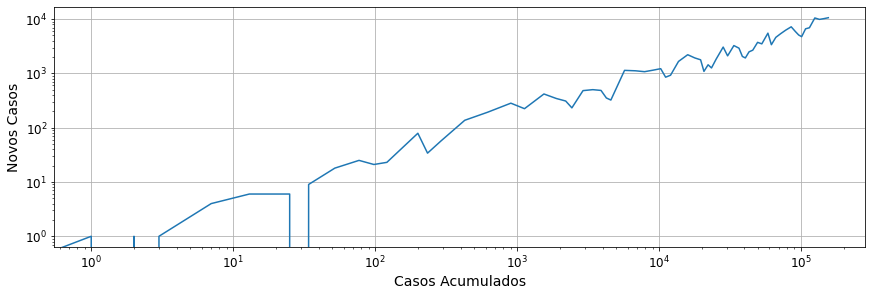

In [51]:
data_ce = state_data = get_state_data(data, "CE")
data_brasil = data.groupby("data").sum()

fig2, ax2 = plt.subplots(1, 1, figsize=(12, 4))
ax2.grid(True)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.plot(data_brasil.casosAcumulados, data_brasil.casosNovos)
ax2.set_ylabel("Novos Casos")
ax2.set_xlabel("Casos Acumulados")
plt.show(fig2)

# Outros

In [52]:
# import requests


In [53]:
# r = requests.get('https://covid.saude.gov.br/')

In [54]:
# r